<a href="https://colab.research.google.com/github/MinakoNG63/DSFB/blob/main/21_Data_Pipeline_on_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 21) Data Pipeline on Titanic Dataset

Term 1 2022 - Instructor: Teerapong Leelanupab

Teaching Assistant:
1. Piyawat Chuangkrud (Sam)
2. Suvapat Manu (Mint)

***

In [ ]:
import pandas as pd
# This is for setting an output to show more row

pd.set_option('display.max_colwidth', None)
# pd.set_option('max_rows', 500)
#pd.set_option('max_colwidth', 400)
# pd.describe_option('max_colwidth')

In [ ]:
#---------------------------------
#download files จาก google drive
#---------------------------------
#dataurl = 'https://drive.google.com/file/d/1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw/view?usp=sharing'
!gdown --id 1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw

Downloading...
From: https://drive.google.com/uc?id=1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw
To: /content/Titanic_dataset.zip
100% 46.5k/46.5k [00:00<00:00, 67.0MB/s]


In [ ]:
!unzip Titanic_dataset.zip

Archive:  Titanic_dataset.zip
  inflating: titanic.csv             
   creating: pre_split/
  inflating: pre_split/test.csv      
  inflating: pre_split/train.csv     
  inflating: description.txt         


## 1. Load data
## 2. Clean data & Split data into features and a target

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data():
  titanic_df = pd.read_csv('titanic.csv')
  return titanic_df

def clean_data(df):
  df['Cabin'] = df['Cabin'].fillna('nocabin')
  df['Age'] = df['Age'].fillna(df['Age'].mean())
  df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
  return df

def split_data_label(df):
  y = df['Survived']
  X = df.drop('Survived', axis=1)
  return X, y

## 3. Extract Feature

### 3.11 <font color='red'>Feature Extraction **function**</font>

***
We can re-start to run from here

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import normalize
import re

# create a special function to extract the initial
def getinitialfeature(df):
  initial = []
  for i in range(len(df)):
    fn = df['Name'][i]
    initial.append(fn.split(',')[1].split('.')[0].strip())
  return initial

# create a special function to extract the ticket flag (Contain only number or not)
def getnumticket(ticketList):
  numticket = []
  for i in range(len(ticketList)):
    try:
      int(ticketList[i])
      numticket.append(1)
    except:
      numticket.append(0)
  return numticket

# create a special function to extract the Alphabet Prefix of Ticket
def getAlphabetPrefixTicket(df):
    #alphaPrefixDict = []
    alphaPrefixTicket = []
    for i in range(len(df)):
        ticket = df['Ticket'].values[i]
        res = re.findall('^[\w/.]+\s|$', ticket)[0]
        #res = re.findall('^[\w?.!/;:]+\s|$', ticket)[0]

        # res = re.search('^[\w/.]+\s|$', ticket).group()
        # alphaPrefixDict.append((ticket, res.strip()))

        ticketCode =  'Ticket-' + res.strip().translate({ord(i):None for i in '/.'})
        alphaPrefixTicket.append(ticketCode)
#     x = np.array(alphaPrefixTicket)
#     print(np.unique(x))
    df['alphaPrefixTicket'] = alphaPrefixTicket
    alphaPrefix_cats  = [['Ticket-', 'Ticket-A4', 'Ticket-A5', 'Ticket-AS', 'Ticket-C', 'Ticket-CA',
         'Ticket-CASOTON', 'Ticket-FC', 'Ticket-FCC', 'Ticket-Fa', 'Ticket-PC',
         'Ticket-PP', 'Ticket-PPP', 'Ticket-SC', 'Ticket-SCA4', 'Ticket-SCAH',
         'Ticket-SCOW', 'Ticket-SCPARIS', 'Ticket-SCParis', 'Ticket-SOC', 'Ticket-SOP',
         'Ticket-SOPP', 'Ticket-SOTONO2', 'Ticket-SOTONOQ', 'Ticket-SP',
         'Ticket-STONO', 'Ticket-STONO2', 'Ticket-SWPP', 'Ticket-WC', 'Ticket-WEP']]
#     alphaPrefixDummy = pd.get_dummies(df['alphaPrefixTicket'], columns = alphaPrefix_cats, drop_first=True)

    alphaPrefix_ohe = OneHotEncoder(categories = alphaPrefix_cats, drop = 'first')
    alphaPrefix_feature_arr = alphaPrefix_ohe.fit_transform(df[['alphaPrefixTicket']]).toarray()
    #confirm that categories are sorted in the same as pre-defined list
    #print(alphaPrefix_ohe.categories_)
    alphaPrefix_cats[0].remove('Ticket-')
    alphaPrefix_feature_labels = alphaPrefix_cats[0]
    alphaPrefixDummy = pd.DataFrame(alphaPrefix_feature_arr, columns=alphaPrefix_feature_labels)
    return alphaPrefixDummy

# -------------------------------------------------------------------------------------
# create a very special function to put what we do all together
# -------------------------------------------------------------------------------------
def extract_feat(df):
  X = df.copy()
  X = X.drop('PassengerId', axis=1)

  # 3.1 Cabin Zone
  X['CabinZone'] = X['Cabin'].str[0]

  # 3.2 Initial of passenger
  X['Initial'] = getinitialfeature(X)

  # 3.3 ticket flag
  ticketList = X['Ticket'].values
  X['Only_Num_in_Ticket'] = getnumticket(ticketList)

  # ******************************** Additional Block 1: Extract More Features ******************************
  # 3.x ticket prefix
  alphaPrefix=getAlphabetPrefixTicket(X)
  X = X.drop('alphaPrefixTicket', axis=1)
  # *********************************************************************************************************

  # 3.4 Quantize Fare
  quantile_list = [0, .25, .5, .75, 1.]
  quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
  X['Fare_Adaptive_Bin'] = pd.qcut(X['Fare'], q=quantile_list, labels=quantile_labels)

  # 3.7 Drop unwanted features
  # from 3.1 Cabin
  X.drop('Cabin', axis=1, inplace=True)
  # from 3.2 Name
  X.drop('Name', axis=1, inplace=True)
  # from 3.3 Ticket
  X.drop('Ticket', axis=1, inplace=True)

  # 3.8 Encode all categorical features

  # ******************************** Additional Block 2: Encode Pclass **************************************
  # 3.8.x Apply OneHotEncoding to PClass
  pclass_features = pd.get_dummies(X['Pclass'])
  feature_labels = ['Pclass_' + str(cls_label) for cls_label in pclass_features.columns]
  pclass_features.columns = feature_labels
  X = X.drop(columns='Pclass', axis=1)
  # *********************************************************************************************************

  # 3.8.1 Apply OneHotEncoding to CabinZone
  cabin_zone_features = pd.get_dummies(X['CabinZone'])
  feature_labels = ['CabinZone_' + str(cls_label) for cls_label in cabin_zone_features.columns]
  cabin_zone_features.columns = feature_labels

  # 3.8.2 Apply OneHotEncoding to Embarked
  embarked_features = pd.get_dummies(X['Embarked'])
  feature_labels = ['Embarked_' + str(cls_label) for cls_label in embarked_features.columns]
  embarked_features.columns = feature_labels

  # 3.8.3 Apply OneHotEncoding to Fare_Adaptive_Bin
  fare_adap_bin_features = pd.get_dummies(X['Fare_Adaptive_Bin'])
  feature_labels = ['FareAdapBin_' + str(cls_label) for cls_label in fare_adap_bin_features.columns]
  fare_adap_bin_features.columns = feature_labels

  # 3.8.4 Apply Dummy Coding Scheme to Sex (Male flag)
  male_features = pd.get_dummies(X['Sex'], drop_first=True)


  # ******************************** Additional Block 3: Encode Initial *************************************
  # 3.8.5.1 Apply LabelEncoding to Initial
  # enc = LabelEncoder()
  # initial_arr = enc.fit_transform(X['Initial'])
  # initial_features = pd.DataFrame({'Initial_Feature': initial_arr})

  # 3.8.5.2 Apply OneHotEncoding to Initial
  initial_features = pd.get_dummies(X['Initial'])
  feature_labels = ['Initial_' + str(cls_label) for cls_label in initial_features.columns]
  initial_features.columns = feature_labels
  # *********************************************************************************************************


  # *********************************** Additional Block 4: Concatenate Features ****************************
  # 3.9 Cancatenate all features to the original dataframe
  X = pd.concat([X,cabin_zone_features,embarked_features,fare_adap_bin_features, male_features,initial_features],axis=1)

  # ****************Add two more features*******************
  #--------Option 1: add AlphaPrefix-------
  # X = pd.concat([X,cabin_zone_features,embarked_features,fare_adap_bin_features, male_features,initial_features,alphaPrefix],axis=1)
  #--------Option 2: add Pclass and AlphaPrefix-------
  # X = pd.concat([X,pclass_features,cabin_zone_features,embarked_features,fare_adap_bin_features, male_features,initial_features,alphaPrefix],axis=1)
  # *********************************************************************************************************
  #display(X)

  # 3.10 Filter in only numeric features to train a model
  X = X._get_numeric_data()
  display(X)
  print(X.shape)

  # 3.11 Apply feature normalization
  X.loc[:, X.columns] = normalize(X, norm='max')
  #display(X)
  return X

# 4. Create Predictive Model

## 4.1 Simple hold-out spliting

In [ ]:
from sklearn.model_selection import train_test_split

def simple_hold_out_spliting(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 1)
  return X_train, X_test, y_train, y_test

## 4.2 Train/fit model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
def train_model(feat, label):
  #model = LogisticRegression()
  model = GradientBoostingClassifier(random_state=100)
  model.fit(feat, label)
  return model

# 5. Evaluate model

In [ ]:
def eval_acc(prediction, actual):
  acc = sum(prediction == actual) / len(actual)
  return acc

# 6. Run pipeline

In [ ]:
def run_pipeline():
  # 1. Get data
  titanic_df = load_data()

  # 2.1 Clean data
  clean_titanic_df = clean_data(titanic_df.copy())

  print("----- Histogram of 'Survived' -----")
  plt.figure()
  p = clean_titanic_df.Survived.value_counts(normalize=True).plot(kind='bar')
  p.set_xlabel("Survived",fontsize=14)
  p.set_ylabel("Count",fontsize=14)
  plt.show()
  print("Traning set - negative class ratio: " + str(round(len(clean_titanic_df[clean_titanic_df['Survived']==0])/len(clean_titanic_df),2)))

  # 2.2 Split data into X (Features) and y (Target)
  X, y = split_data_label(clean_titanic_df)

  # 3. Extract feature
  X = extract_feat(X)

  # 4. Train model
  X_train, X_test, y_train, y_test = simple_hold_out_spliting(X, y, 0.2)
  model = train_model(X_train, y_train)

  #find the ratio of negative examples in traning and test sets
  print("----- Histogram of 'Survived' in a Traning set -----")
  plt.figure()
  p = y_train.value_counts(normalize=True).plot(kind='bar', color='#ff7f0e')
  p.set_xlabel("Survived",fontsize=14)
  p.set_ylabel("Count",fontsize=14)
  plt.show()
  print("Traning set - negative class ratio: " + str(round(sum(y_train==0)/len(y_train),2)))


  print("----- Histogram of 'Survived' in a Test set -----")
  plt.figure()
  p = y_test.value_counts(normalize=True).plot(kind='bar', color='skyblue')
  p.set_xlabel("Survived",fontsize=14)
  p.set_ylabel("Count",fontsize=14)
  plt.show()
  print("Test set - negative class ratio: " + str(round(sum(y_test==0)/len(y_test),2)))

  # 5. Prediction
  train_prediction = model.predict(X_train)
  test_prediction = model.predict(X_test)

  # 6. Evaluation
  train_acc = eval_acc(train_prediction, y_train)
  test_acc = eval_acc(test_prediction, y_test)

  bias = 1 - train_acc # train_err
  test_err = 1 - test_acc
  variance = test_err - bias

  return train_acc, test_acc, bias, variance

----- Histogram of 'Survived' -----


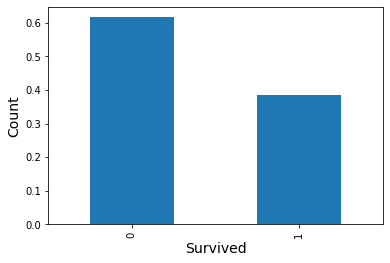

Traning set - negative class ratio: 0.62


,Sex,Age,SibSp,Parch,Fare,Embarked,CabinZone,Initial,Only_Num_in_Ticket,Fare_Adaptive_Bin,CabinZone_A,CabinZone_B,CabinZone_C,CabinZone_D,CabinZone_E,CabinZone_F,CabinZone_G,CabinZone_T,CabinZone_n,Embarked_C,Embarked_Q,Embarked_S,FareAdapBin_0-25Q,FareAdapBin_25-50Q,FareAdapBin_50-75Q,FareAdapBin_75-100Q,male,Initial_Capt,Initial_Col,Initial_Don,Initial_Dr,Initial_Jonkheer,Initial_Lady,Initial_Major,Initial_Master,Initial_Miss,Initial_Mlle,Initial_Mme,Initial_Mr,Initial_Mrs,Initial_Ms,Initial_Rev,Initial_Sir,Initial_the Countess
0,male,22.000000,1,0,7.2500,S,n,Mr,0,0-25Q,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,female,38.000000,1,0,71.2833,C,C,Mrs,0,75-100Q,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,female,26.000000,0,0,7.9250,S,n,Miss,0,25-50Q,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,female,35.000000,1,0,53.1000,S,C,Mrs,1,75-100Q,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,male,35.000000,0,0,8.0500,S,n,Mr,1,25-50Q,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,male,27.000000,0,0,13.0000,S,n,Rev,1,25-50Q,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
887,female,19.000000,0,0,30.0000,S,B,Miss,1,50-75Q,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
888,female,29.699118,1,2,23.4500,S,n,Miss,0,50-75Q,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
889,male,26.000000,0,0,30.0000,C,C,Mr,1,50-75Q,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


,Age,SibSp,Parch,Fare,Only_Num_in_Ticket,CabinZone_A,CabinZone_B,CabinZone_C,CabinZone_D,CabinZone_E,CabinZone_F,CabinZone_G,CabinZone_T,CabinZone_n,Embarked_C,Embarked_Q,Embarked_S,FareAdapBin_0-25Q,FareAdapBin_25-50Q,FareAdapBin_50-75Q,FareAdapBin_75-100Q,male,Initial_Capt,Initial_Col,Initial_Don,Initial_Dr,Initial_Jonkheer,Initial_Lady,Initial_Major,Initial_Master,Initial_Miss,Initial_Mlle,Initial_Mme,Initial_Mr,Initial_Mrs,Initial_Ms,Initial_Rev,Initial_Sir,Initial_the Countess
0,22.000000,1,0,7.2500,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,38.000000,1,0,71.2833,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,26.000000,0,0,7.9250,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,35.000000,1,0,53.1000,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,35.000000,0,0,8.0500,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.000000,0,0,13.0000,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
887,19.000000,0,0,30.0000,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
888,29.699118,1,2,23.4500,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
889,26.000000,0,0,30.0000,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


(891, 39)
----- Histogram of 'Survived' in a Traning set -----


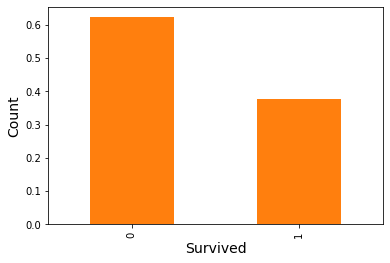

Traning set - negative class ratio: 0.62
----- Histogram of 'Survived' in a Test set -----


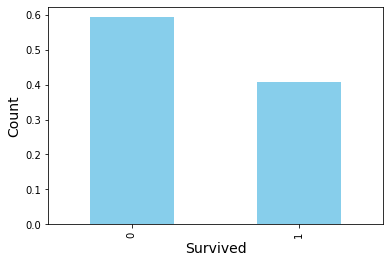

Test set - negative class ratio: 0.59


In [ ]:
train_acc, test_acc, bias, variance = run_pipeline()

In [ ]:
print("--------------------")
print("Training Acc: " + str(train_acc))
print("Test Acc: " + str(test_acc))
print("Bias: " + str(bias))
print("Varaince: " + str(variance))

--------------------
Training Acc: 0.9297752808988764
Test Acc: 0.7541899441340782
Bias: 0.0702247191011236
Varaince: 0.17558533676479815
